In [1]:
import numpy as np
import pandas as pd
import os
import math
from operator import truediv
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
import warnings
warnings.filterwarnings('ignore')
!pip install pytorch-metric-learning
import pytorch_metric_learning
from pytorch_metric_learning import distances, losses, miners, reducers, testers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)


windowSize = 25
batch_size = 32


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def padding(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

def createPatch(X, y, windowSize=windowSize):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padding(X, margin=margin)

    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1


    patchesData = patchesData[patchesLabels > 0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels > 0]
    patchesLabels -= 1


    patchesData = patchesData.transpose((0, 3, 1, 2))

    return patchesData, patchesLabels


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX

In [4]:
def splitTrainTestSet(X, y, randomState=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
from scipy.io import loadmat

X=np.load("/content/drive/MyDrive/dml/indian-veriseti/indianpinearray.npy")
y=np.load("/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy")



X=applyPCA(X)

X,y=createPatch(X,y)

mean = np.mean(X)
std = np.std(X)

X = (X - mean) / std

X_train, X_val, X_test, y_train, y_val, y_test = splitTrainTestSet(X, y, randomState=42)
print(X.shape)
print(y.shape)


(10249, 15, 25, 25)
(10249,)


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class HSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        image = torch.from_numpy(image).float()
        label = torch.tensor(label).long()

        return image, label

In [7]:
batch_size = 32

train_dataset = HSIDataset(X_train, y_train)
val_dataset = HSIDataset(X_val, y_val)
test_dataset = HSIDataset(X_test, y_test)


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [8]:
class CNNetwork(nn.Module):
    def __init__(self):
        super(CNNetwork, self).__init__()

        self.conv1 = nn.Conv2d(15, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc4 = nn.Linear(128 * 3 * 3, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, 128)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)


        return x

In [9]:
device = torch.device("cuda")

model = CNNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

mining_func = miners.TripletMarginMiner()

In [10]:
def train(model, loss_func, mining_func, device, train_loader, optimizer,val_loader):
    loss_array = []
    val_loss_array = []
    for epoch in range(1, 20):
        loss_run_array = []
        model.train()
        for batch_idx,(data,labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(data)
            indices_tuple = mining_func(embeddings, labels)
            loss = loss_func(embeddings, labels, indices_tuple)
            loss_run_array.append(loss.item())
            loss.backward()
            optimizer.step()
            if batch_idx % 5 == 0:
                print(
                    "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                        epoch, batch_idx, loss, mining_func.num_triplets
                    )
                )
        loss_eval=evaluate(model,loss_func,mining_func,device,val_loader)
        val_loss_array.append(loss_eval)
        avg= sum(loss_run_array) / (len(loss_run_array)-1)
        loss_array.append(avg)

    return loss_array,val_loss_array

In [11]:
def evaluate(model,loss_func,mining_func,device,validasyon_loader):
      avg_loss=0
      model.eval()
      with torch.no_grad():
          running_loss = []
          for batch_idx, (data, labels) in enumerate(validasyon_loader):
              data, labels = data.to(device), labels.to(device)
              embeddings = model(data)

              indices_tuple = mining_func(embeddings, labels)
              loss_value = loss_func(embeddings, labels, indices_tuple)
              running_loss.append(loss_value.item())



          avg_loss = sum(running_loss) / len(running_loss)


      return avg_loss



In [12]:
loss_func = losses.LiftedStructureLoss()

In [13]:
loss_mean,val_loss_arr=train(model, loss_func, mining_func, device, train_loader, optimizer,val_loader)

Epoch 1 Iteration 0: Loss = 18.93306541442871, Number of mined triplets = 2105
Epoch 1 Iteration 5: Loss = 19.989850997924805, Number of mined triplets = 2886
Epoch 1 Iteration 10: Loss = 21.04332160949707, Number of mined triplets = 3294
Epoch 1 Iteration 15: Loss = 19.16227912902832, Number of mined triplets = 2288
Epoch 1 Iteration 20: Loss = 17.796104431152344, Number of mined triplets = 1613
Epoch 1 Iteration 25: Loss = 16.46492576599121, Number of mined triplets = 1389
Epoch 1 Iteration 30: Loss = 15.863593101501465, Number of mined triplets = 1170
Epoch 1 Iteration 35: Loss = 16.387161254882812, Number of mined triplets = 1440
Epoch 1 Iteration 40: Loss = 16.35239601135254, Number of mined triplets = 1360
Epoch 1 Iteration 45: Loss = 14.966483116149902, Number of mined triplets = 1084
Epoch 1 Iteration 50: Loss = 17.059343338012695, Number of mined triplets = 1647
Epoch 1 Iteration 55: Loss = 15.679391860961914, Number of mined triplets = 1118
Epoch 1 Iteration 60: Loss = 13.358

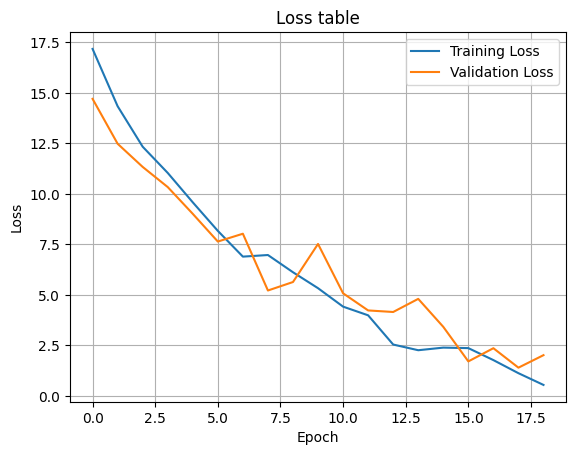

In [14]:
index = range(len(loss_mean))

# Çizim işlemi
plt.plot(index, loss_mean, label='Training Loss')
plt.plot(index, val_loss_arr, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss table')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
torch.save(model, 'model_LiftedStructreLoss_indian.pth')

In [16]:
class FeatureDataset():
    def __init__(self, feature, feature_labels):
        self.data = feature
        self.labels = feature_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [17]:
model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(val_loader):
              data, labels = data.to(device), labels.to(device)
              embeddings= model(data)
              all_features.append(embeddings)
              all_labels.append(labels)

print(all_features[0].shape)




torch.Size([32, 128])


In [18]:
concatenated_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)


In [19]:
min_values_tensor = torch.min(concatenated_features, dim=0)[0]
max_values_tensor = torch.max(concatenated_features, dim=0)[0]

all_features = (concatenated_features - min_values_tensor) / (max_values_tensor - min_values_tensor)
dataset = FeatureDataset(all_features, all_labels)
Feature_train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [20]:
model.eval()
test_features = []
test_labels = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
          data, labels = data.to(device), labels.to(device)
          embeddings= model(data)
          test_features.append(embeddings)
          test_labels.append(labels)

In [21]:
test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

test_features = (test_features - min_values_tensor) / (max_values_tensor - min_values_tensor)

dataset_test = FeatureDataset(test_features, test_labels)
Feature_test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [22]:
class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.fc8 = nn.Linear(128,256)
        self.relu1=nn.ReLU(inplace=True)
        self.fc9=nn.Linear(256,512)
        self.relu2=nn.ReLU(inplace=True)
        self.fc10=nn.Linear(512,128)
        self.relu3=nn.ReLU(inplace=True)
        self.fc11=nn.Linear(128,64)
        self.relu4=nn.ReLU(inplace=True)
        self.fc6 = nn.Linear(64, 32)
        self.relu = nn.ReLU(inplace=True)
        self.fc7 = nn.Linear(32, 16)

    def forward(self, x):

        x = self.fc8(x)
        x=self.relu1(x)
        x = self.fc9(x)
        x=self.relu2(x)
        x = self.fc10(x)
        x=self.relu3(x)
        x = self.fc11(x)
        x=self.relu4(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)


        return x

In [23]:
classificationModel = ClassificationNN()
optimizer_feature = optim.Adam(classificationModel.parameters(), lr=0.001)
loss_for_classification = nn.CrossEntropyLoss()


In [24]:
for param in classificationModel.parameters():
    param.requires_grad = True

In [25]:
def evaluate_classification(model, test_class_dl, clas_loss_fn, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_class_dl:
            targets= targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = clas_loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_loss = total_loss / len(test_class_dl)
    accuracy = (correct / total) * 100

    return average_loss, accuracy




In [26]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classification(model_classification, feat_train_loader, feat_criterion, feat_optimizer, device, test_class_dl):
    model_classification.to(device)
    model_classification.train()

    loss_list = []
    epoch_accuracies = []
    evaluation_losses = []
    evaluation_accuracies = []

    for epoch in tqdm(range(20), desc="Epochs"):
        model_classification.train()
        all_labels = []
        all_predictions = []
        epoch_loss_list = []

        for inputs, labels in feat_train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            feat_optimizer.zero_grad()
            outputs = model_classification(inputs)
            loss = feat_criterion(outputs, labels)
            loss.backward()
            feat_optimizer.step()

            epoch_loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        epoch_accuracies.append(accuracy)
        loss_list.extend(epoch_loss_list)

        eval_loss, eval_accuracy = evaluate_classification(model_classification, test_class_dl, feat_criterion, device)
        evaluation_losses.append(eval_loss)
        evaluation_accuracies.append(eval_accuracy)

        print(f"Epoch {epoch+1}/{20}, Training Loss: {sum(epoch_loss_list)/len(epoch_loss_list):.4f}, Training Accuracy: {accuracy:.4f}")
        print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.2f}%")

    return loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies


In [27]:
loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies = train_classification(classificationModel,Feature_train_loader,loss_for_classification,optimizer_feature,device,Feature_test_loader)

Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.92it/s]

Epoch 1/20, Training Loss: 1.3066, Training Accuracy: 0.5870
Validation Loss: 0.3250, Validation Accuracy: 92.54%


Epochs:  10%|█         | 2/20 [00:00<00:08,  2.14it/s]

Epoch 2/20, Training Loss: 0.1661, Training Accuracy: 0.9549
Validation Loss: 0.1254, Validation Accuracy: 96.83%


Epochs:  15%|█▌        | 3/20 [00:01<00:07,  2.22it/s]

Epoch 3/20, Training Loss: 0.0787, Training Accuracy: 0.9756
Validation Loss: 0.0592, Validation Accuracy: 98.08%


Epochs:  20%|██        | 4/20 [00:01<00:07,  2.26it/s]

Epoch 4/20, Training Loss: 0.0858, Training Accuracy: 0.9721
Validation Loss: 0.0451, Validation Accuracy: 98.68%


Epochs:  25%|██▌       | 5/20 [00:02<00:06,  2.26it/s]

Epoch 5/20, Training Loss: 0.0598, Training Accuracy: 0.9830
Validation Loss: 0.0770, Validation Accuracy: 97.32%


Epochs:  30%|███       | 6/20 [00:02<00:06,  2.27it/s]

Epoch 6/20, Training Loss: 0.0400, Training Accuracy: 0.9877
Validation Loss: 0.0441, Validation Accuracy: 98.78%


Epochs:  35%|███▌      | 7/20 [00:03<00:05,  2.27it/s]

Epoch 7/20, Training Loss: 0.0671, Training Accuracy: 0.9777
Validation Loss: 0.0696, Validation Accuracy: 97.84%


Epochs:  40%|████      | 8/20 [00:03<00:05,  2.26it/s]

Epoch 8/20, Training Loss: 0.0573, Training Accuracy: 0.9807
Validation Loss: 0.0509, Validation Accuracy: 98.57%


Epochs:  45%|████▌     | 9/20 [00:04<00:04,  2.27it/s]

Epoch 9/20, Training Loss: 0.0509, Training Accuracy: 0.9844
Validation Loss: 0.0554, Validation Accuracy: 98.43%


Epochs:  50%|█████     | 10/20 [00:04<00:04,  2.28it/s]

Epoch 10/20, Training Loss: 0.0461, Training Accuracy: 0.9858
Validation Loss: 0.0267, Validation Accuracy: 99.13%


Epochs:  55%|█████▌    | 11/20 [00:04<00:04,  2.25it/s]

Epoch 11/20, Training Loss: 0.0698, Training Accuracy: 0.9779
Validation Loss: 0.0458, Validation Accuracy: 98.54%


Epochs:  60%|██████    | 12/20 [00:05<00:03,  2.25it/s]

Epoch 12/20, Training Loss: 0.0385, Training Accuracy: 0.9875
Validation Loss: 0.0289, Validation Accuracy: 99.13%


Epochs:  65%|██████▌   | 13/20 [00:05<00:03,  2.17it/s]

Epoch 13/20, Training Loss: 0.0513, Training Accuracy: 0.9840
Validation Loss: 0.0278, Validation Accuracy: 99.23%


Epochs:  70%|███████   | 14/20 [00:06<00:02,  2.20it/s]

Epoch 14/20, Training Loss: 0.0290, Training Accuracy: 0.9895
Validation Loss: 0.0292, Validation Accuracy: 99.30%


Epochs:  75%|███████▌  | 15/20 [00:06<00:02,  2.23it/s]

Epoch 15/20, Training Loss: 0.0523, Training Accuracy: 0.9865
Validation Loss: 0.0587, Validation Accuracy: 98.40%


Epochs:  80%|████████  | 16/20 [00:07<00:01,  2.25it/s]

Epoch 16/20, Training Loss: 0.0482, Training Accuracy: 0.9854
Validation Loss: 0.0304, Validation Accuracy: 99.23%


Epochs:  85%|████████▌ | 17/20 [00:07<00:01,  2.26it/s]

Epoch 17/20, Training Loss: 0.0313, Training Accuracy: 0.9909
Validation Loss: 0.0626, Validation Accuracy: 97.80%


Epochs:  90%|█████████ | 18/20 [00:08<00:00,  2.25it/s]

Epoch 18/20, Training Loss: 0.0516, Training Accuracy: 0.9856
Validation Loss: 0.0336, Validation Accuracy: 98.82%


Epochs:  95%|█████████▌| 19/20 [00:08<00:00,  2.25it/s]

Epoch 19/20, Training Loss: 0.0226, Training Accuracy: 0.9944
Validation Loss: 0.0337, Validation Accuracy: 98.99%


Epochs: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]

Epoch 20/20, Training Loss: 0.0282, Training Accuracy: 0.9898
Validation Loss: 0.0601, Validation Accuracy: 98.22%


In [28]:
torch.save(classificationModel,'model_classification_LiftedStructreLoss_indian.pth')

In [29]:
###deniyorum

hsi_all = HSIDataset(X,y)

hsi_loader = torch.utils.data.DataLoader(
    hsi_all, batch_size=32, shuffle=False
)

model.eval()
all_hsi_features = []
all_hsi_labels = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(hsi_loader):
              data, labels = data.to(device), labels.to(device)
              embeddings= model(data)

              all_hsi_features.append(embeddings)
              all_hsi_labels.append(labels)


concatenated_hsi_features = torch.cat(all_hsi_features, dim=0)
all_labels = torch.cat(all_hsi_labels, dim=0)
print(all_labels.shape)
all_hsi_features = (concatenated_hsi_features - min_values_tensor) / (max_values_tensor - min_values_tensor)
print(all_hsi_features.shape)

hsi_feature_dataset = FeatureDataset(all_hsi_features, all_labels)


hsi_Feature_loader = DataLoader(hsi_feature_dataset, batch_size=32, shuffle=False)

torch.Size([10249])
torch.Size([10249, 128])


In [30]:
#deniyorum

predict_array = []

with torch.no_grad():
        for inputs, targets in hsi_Feature_loader:
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = classificationModel(inputs)

            _, predicted = torch.max(outputs, 1)
            predict_array.append(predicted)




In [31]:
new_list = []
for tensor in predict_array:
    for item in tensor:
            new_list.append(item.item())


In [32]:
torch.save(min_values_tensor, 'min_values_indian_LiftedStructure.pt')
torch.save(max_values_tensor, 'max_values_indian_LiftedStructure.pt')

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score

s=accuracy_score(y,new_list)
c=cohen_kappa_score(y,new_list)
f1=f1_score(y,new_list,average='weighted')
print("Accuracy:",s)
print("Cohen Kappa Score:",c)
print("F1 Score:",f1)

Accuracy: 0.987315835691287
Cohen Kappa Score: 0.9855421207200203
F1 Score: 0.9867218620667039


In [34]:
gt_2=np.load("/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy")
gt_2=gt_2.reshape(-1)

c=0
d=0
i=0
for i in range(21025):
    if gt_2[i] != 0:
              gt_2[i]=(new_list[d] + 1)
              d += 1



In [35]:
gt_2=gt_2.reshape(145,-1)

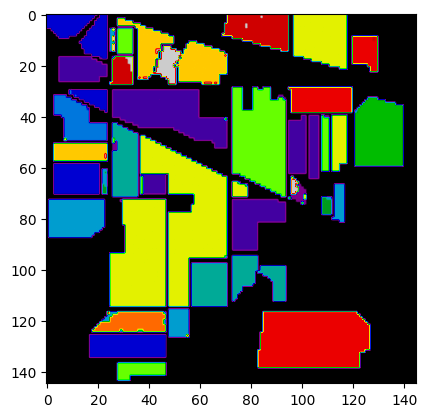

In [36]:

plt.imshow(gt_2, cmap='nipy_spectral')
plt.show()

In [37]:
gt_3=np.load("/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy")

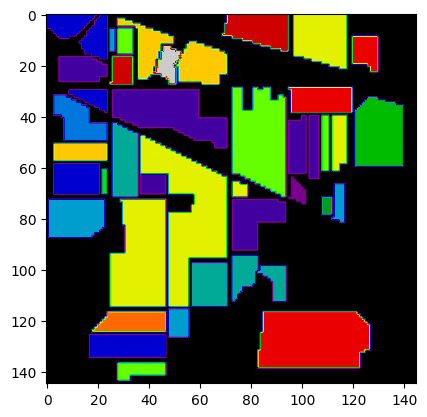

In [38]:
plt.imshow(gt_3,cmap='nipy_spectral')
plt.show()